In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import boxcox

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [24]:
motorbike_df = pd.read_csv("data/motorbike_updated.csv")
motorbike_df

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day_night
0,1,2011-01-01,0,0,1,0,0,6,0,1,0.24,0.81,0.0000,16,0
1,2,2011-01-01,0,0,1,1,0,6,0,1,0.22,0.80,0.0000,40,0
2,3,2011-01-01,0,0,1,2,0,6,0,1,0.22,0.80,0.0000,32,0
3,4,2011-01-01,0,0,1,3,0,6,0,1,0.24,0.75,0.0000,13,0
4,5,2011-01-01,0,0,1,4,0,6,0,1,0.24,0.75,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,0,1,12,19,0,1,1,2,0.26,0.60,0.1642,119,1
17375,17376,2012-12-31,0,1,12,20,0,1,1,2,0.26,0.60,0.1642,89,1
17376,17377,2012-12-31,0,1,12,21,0,1,1,1,0.26,0.60,0.1642,90,1
17377,17378,2012-12-31,0,1,12,22,0,1,1,1,0.26,0.56,0.1343,61,0


So, firstly i want to test it out on the default **xgboost reggression** model, but with a little adjustments using **GridSearch**. Let's see what results we will get.

In [25]:
motorbike_df = motorbike_df.drop("date", axis=1)

scaler = StandardScaler()

X = motorbike_df.drop(["cnt"], axis=1)
y = motorbike_df["cnt"]

X_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train_unscaled)
x_test = scaler.transform(x_test_unscaled)

In [26]:
xgb_model = xgb.XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

xgb_model_gs = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3)

xgb_model_gs.fit(X_train, y_train)

xgb_pred = xgb_model_gs.predict(x_test)

l_mse_lr = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost Mean Squared Error: {l_mse_lr:.2f}')
l_r2_lr = r2_score(y_test, xgb_pred)
print(f'XGBoost R^2 Score: {l_r2_lr:.2f}')

XGBoost Mean Squared Error: 1544.01
XGBoost R^2 Score: 0.95


**R^2 score is 0.95** which is already very good, and we could stop :)

But, we will train other models too \
Next, i want to try using **BoxCox** method for our training.

In [27]:
motorbike_df["cnt_boxcox"], lambda_boxcox = boxcox(motorbike_df["cnt"] + 1)
print(f"Box-Cox lambda: {lambda_boxcox:.3f}")

Box-Cox lambda: 0.294


Text(0.5, 1.0, 'Dist With BoxCox')

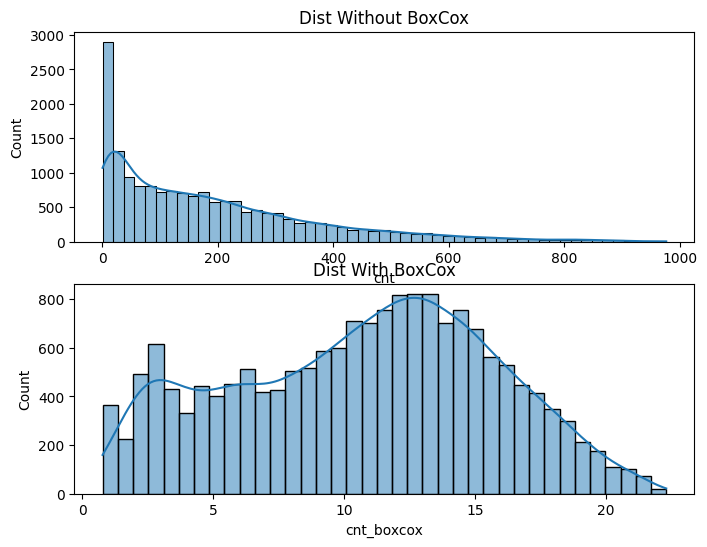

In [28]:
_, ax = plt.subplots(2, 1, figsize=(8,6))
sns.histplot(motorbike_df["cnt"], kde=True, ax=ax[0]).set_title("Dist Without BoxCox")
sns.histplot(motorbike_df["cnt_boxcox"], kde=True, ax=ax[1]).set_title("Dist With BoxCox")

In [29]:
scaler = StandardScaler()

X = motorbike_df.drop(["cnt", "cnt_boxcox"], axis=1)
y = motorbike_df["cnt_boxcox"]

X_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(x_test_unscaled)

In [36]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=2, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

y_pred_rf_inverse = np.exp(np.log(lambda_boxcox * y_pred_rf + 1) / lambda_boxcox)

rmse_rf = mean_squared_error(
    np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox), 
    y_pred_rf_inverse, 
    squared=False
)
print(f"Random Forest RMSE with GridSearch: {rmse_rf:.3f}")

r2_rf = r2_score(
    np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox), 
    y_pred_rf_inverse
)
print(f"Random Forest R² with GridSearch: {r2_rf:.3f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest RMSE with GridSearch: 39.950
Random Forest R² with GridSearch: 0.950


In [44]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': 42
}

lgb_model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_test])

y_pred_lgb = lgb_model.predict(X_test)

y_pred_lgb_inverse = np.exp(np.log(lambda_boxcox * y_pred_lgb + 1) / lambda_boxcox)

rmse_lgb = mean_squared_error(np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox), y_pred_lgb_inverse, squared=False)
print(f"\nLightGBM RMSE: {rmse_lgb:.3f}")

r2_lgb = r2_score(
    np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox), 
    y_pred_lgb_inverse
)
print(f"LightGBM R²: {r2_lgb:.3f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 13903, number of used features: 13
[LightGBM] [Info] Start training from score 10.702095

LightGBM RMSE: 40.227
LightGBM R²: 0.949


So, our models did great job. I've trained Random Forest with Grid Search and the R^2 score is **0.950** which is pretty good result. \
And another model is LightGBM which gave us same result of **0.949** which is totally pleasable. \
Firstly, i wanted to train **NARIMAX** model, but it didn't go well, and my model wasn't working. So, i decided to stick to this two models. \
Also, XGBoost did a good job, we can take into consideration this model too, with result: **0.950**.

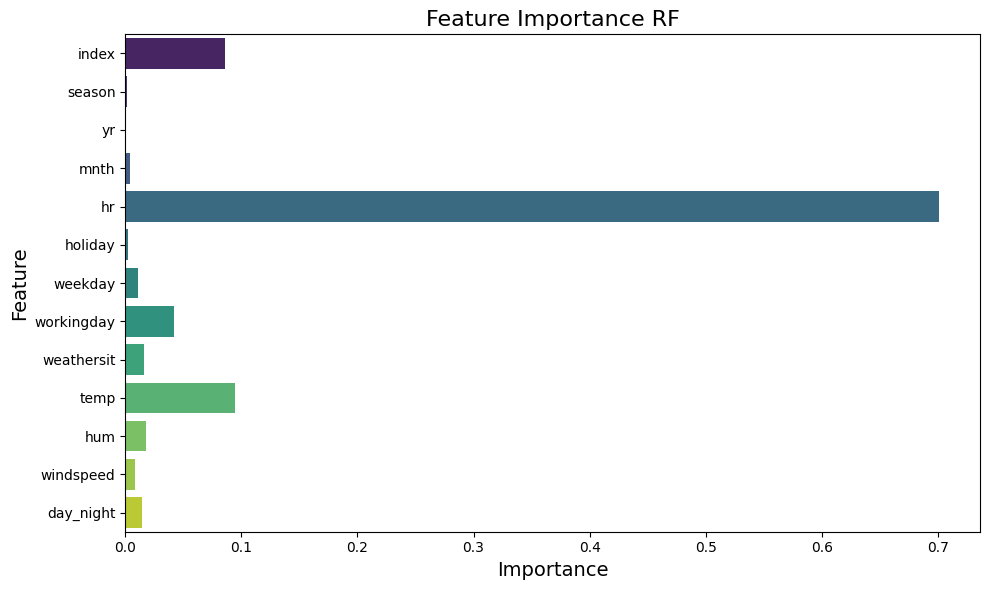

In [49]:
feature_importances = best_rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, orient='h', palette='viridis')
plt.title('Feature Importance RF', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

If we talk about Feature Importance, the most important feature was **hr** which is hour of the day, **temp** and **working day**.

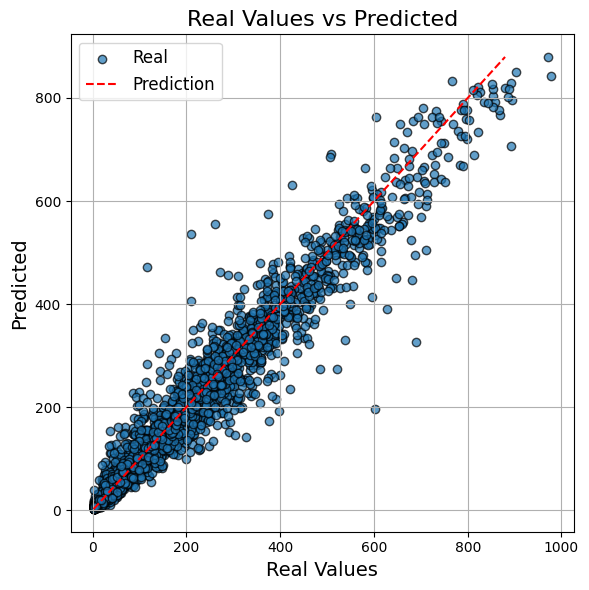

In [56]:
plt.figure(figsize=(6, 6))
plt.scatter(
    np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox), 
    y_pred_lgb_inverse, 
    alpha=0.7, edgecolor='k', label='Real'
)
plt.plot(
    [min(y_pred_lgb_inverse), max(y_pred_lgb_inverse)], 
    [min(y_pred_lgb_inverse), max(y_pred_lgb_inverse)], 
    color='red', linestyle='--', label='Prediction'
)
plt.title('Real Values vs Predicted', fontsize=16)
plt.xlabel('Real Values', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()


This plot shows us that predicted values is almost ideal as the real ones. So, our models did good job, and gave us really great results in Regression model training.